# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [homework page](https://comp150dl.github.io/hw/) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [28]:
# Run some setup code for this notebook.

import random
import numpy as np
from hw1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [29]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


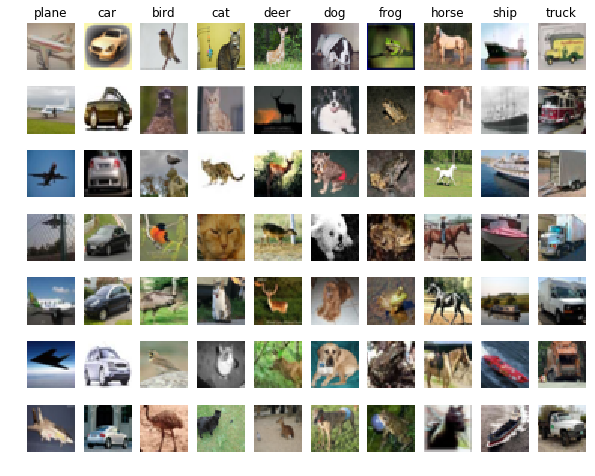

In [30]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [31]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [32]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


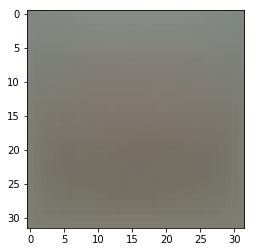

In [33]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [34]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [35]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **hw1/classifiers/linear_svm.py**. 

As you can see, we have sketched out the function `structured_loss_simple` which uses for loops to evaluate the multiclass SVM loss function. 

In [36]:
# Evaluate the naive implementation of the loss we provided for you:
from hw1.classifiers.linear_svm import structured_loss_simple
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = structured_loss_simple(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 8.911247


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `structured_loss_simple`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [37]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = structured_loss_simple(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
print"without regularization"
from hw1.gradient_check import grad_check_sparse
f = lambda w: structured_loss_simple(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print "with regularization"
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = structured_loss_simple(W, X_dev, y_dev, 1e2)
f = lambda w: structured_loss_simple(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

without regularization
numerical: 17.730142 analytic: 17.730142, relative error: 3.022688e-12
numerical: 28.533036 analytic: 28.533036, relative error: 9.440958e-12
numerical: -2.069934 analytic: -2.069934, relative error: 1.451282e-10
numerical: 41.416420 analytic: 41.416420, relative error: 3.171384e-12
numerical: -11.162523 analytic: -11.162523, relative error: 1.421035e-11
numerical: -1.457656 analytic: -1.410849, relative error: 1.631747e-02
numerical: -9.927031 analytic: -9.927031, relative error: 8.499717e-13
numerical: 5.916404 analytic: 5.916404, relative error: 9.582245e-13
numerical: -31.346019 analytic: -31.346019, relative error: 2.610471e-12
numerical: -32.892127 analytic: -32.892127, relative error: 1.002127e-11
with regularization
numerical: 3.558307 analytic: 3.558307, relative error: 6.669405e-11
numerical: -0.299190 analytic: -0.299190, relative error: 1.507129e-09
numerical: -2.950690 analytic: -2.950690, relative error: 1.315542e-10
numerical: -0.140493 analytic: -

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 
Since SVM loss function is not strictly speaking differentiable, such a discrepancy maybe casued by numerical error, it won't be a big concern. In one dimension, if it contains a kink, then a gradient check may fail.


In [38]:
# Next implement the function svm_loss_fast; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = structured_loss_simple(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from hw1.classifiers.linear_svm import structured_loss_fast
tic = time.time()
loss_vectorized, _ = structured_loss_fast(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 8.911247e+00 computed in 0.162724s
Vectorized loss: 8.911247e+00 computed in 0.025767s
difference: 0.000000


In [39]:
# Complete the implementation of svm_loss_fast, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = structured_loss_simple(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = structured_loss_fast(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.172195s
Vectorized loss and gradient: computed in 0.009521s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [40]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from hw1.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 788.149730
iteration 100 / 1500: loss 288.328858
iteration 200 / 1500: loss 107.979262
iteration 300 / 1500: loss 42.562763
iteration 400 / 1500: loss 19.166867
iteration 500 / 1500: loss 10.056365
iteration 600 / 1500: loss 7.496789
iteration 700 / 1500: loss 5.782869
iteration 800 / 1500: loss 5.474365
iteration 900 / 1500: loss 5.072434
iteration 1000 / 1500: loss 5.272426
iteration 1100 / 1500: loss 5.192622
iteration 1200 / 1500: loss 5.419663
iteration 1300 / 1500: loss 4.670618
iteration 1400 / 1500: loss 5.237072
That took 12.190040s


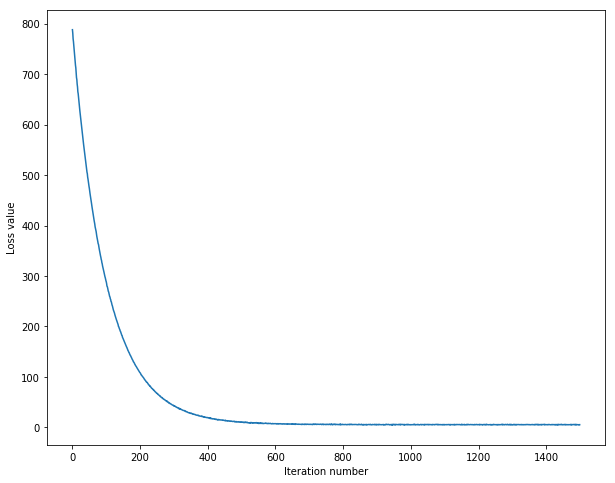

In [41]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [42]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.368327
validation accuracy: 0.371000


In [53]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [9e-8, 7e-8, 1e-8]
#regularization_strengths = [5e-1, 1e-2]
learning_rates = [9e-8, 7e-8, 9e-7]
regularization_strengths = [1e-2, 5e-2, 1e-3, 2e-3, 1e-4]
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_params = None
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for learn_rate in learning_rates:
    for re in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate = learn_rate, reg = re,
                      num_iters=3000)
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(learn_rate, re)] = (training_accuracy,validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            best_params = [learn_rate, re]
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 7.000000e-08 reg 1.000000e-04 train accuracy: 0.313367 val accuracy: 0.326000
lr 7.000000e-08 reg 1.000000e-03 train accuracy: 0.314510 val accuracy: 0.315000
lr 7.000000e-08 reg 2.000000e-03 train accuracy: 0.319939 val accuracy: 0.332000
lr 7.000000e-08 reg 1.000000e-02 train accuracy: 0.316306 val accuracy: 0.334000
lr 7.000000e-08 reg 5.000000e-02 train accuracy: 0.316776 val accuracy: 0.307000
lr 9.000000e-08 reg 1.000000e-04 train accuracy: 0.322327 val accuracy: 0.343000
lr 9.000000e-08 reg 1.000000e-03 train accuracy: 0.324347 val accuracy: 0.325000
lr 9.000000e-08 reg 2.000000e-03 train accuracy: 0.326449 val accuracy: 0.329000
lr 9.000000e-08 reg 1.000000e-02 train accuracy: 0.326122 val accuracy: 0.335000
lr 9.000000e-08 reg 5.000000e-02 train accuracy: 0.321776 val accuracy: 0.321000
lr 9.000000e-07 reg 1.000000e-04 train accuracy: 0.384020 val accuracy: 0.369000
lr 9.000000e-07 reg 1.000000e-03 train accuracy: 0.380143 val accuracy: 0.365000
lr 9.000000e-07 reg 2.000000

In [55]:
# Optional: Continue training best_svm to obtain lower loss 
best_svm.train(X_train, y_train, learning_rate=best_params[0], reg=best_params[1],
                num_iters=50000, verbose=True)

iteration 0 / 50000: loss 3.181222
iteration 100 / 50000: loss 4.192678
iteration 200 / 50000: loss 3.592155
iteration 300 / 50000: loss 3.568861
iteration 400 / 50000: loss 3.529337
iteration 500 / 50000: loss 3.595042
iteration 600 / 50000: loss 4.819254
iteration 700 / 50000: loss 4.164933
iteration 800 / 50000: loss 3.822190
iteration 900 / 50000: loss 5.370155
iteration 1000 / 50000: loss 4.322452
iteration 1100 / 50000: loss 3.632281
iteration 1200 / 50000: loss 3.929068
iteration 1300 / 50000: loss 4.390818
iteration 1400 / 50000: loss 3.568407
iteration 1500 / 50000: loss 4.109972
iteration 1600 / 50000: loss 3.574951
iteration 1700 / 50000: loss 3.727911
iteration 1800 / 50000: loss 3.517357
iteration 1900 / 50000: loss 4.294462
iteration 2000 / 50000: loss 3.763355
iteration 2100 / 50000: loss 4.444052
iteration 2200 / 50000: loss 4.763229
iteration 2300 / 50000: loss 3.899254
iteration 2400 / 50000: loss 4.024693
iteration 2500 / 50000: loss 3.885497
iteration 2600 / 50000: 

[3.1812217080396761,
 3.8451727238893239,
 3.5928859144394165,
 4.1477170805488139,
 3.9957462224944855,
 3.3701036202607559,
 4.0620733426482882,
 3.7658740242321271,
 4.1843881193163002,
 4.2872776609761303,
 3.8929594503293417,
 3.5903052098111417,
 3.8569788142912445,
 4.2784463620737565,
 3.7997419842537341,
 3.8604582918394126,
 3.7262402552051412,
 3.9931199279814602,
 3.3626723927842153,
 4.6115331326615498,
 4.7429606536243201,
 3.5957961702951398,
 3.9949573627234907,
 3.5740395740281463,
 3.4362134371584747,
 4.1670518710363771,
 3.9521886571391058,
 4.7118026855182125,
 3.7647275976411541,
 3.9582385456760139,
 3.3520527235834794,
 3.8670942688800176,
 3.6300224815223081,
 4.6686555205656779,
 4.1867157412252443,
 3.6284180594762532,
 4.0483711992353877,
 4.3927962886586576,
 4.4332905605778228,
 3.9294044836101429,
 4.1894363990966985,
 3.869323614085503,
 3.739221350021853,
 3.5486140235168371,
 3.8611266537602607,
 3.7898264571401663,
 3.3464664897601875,
 4.235813157953

In [61]:
y_train_pred = best_svm.predict(X_train)
train_acc = np.mean(y_train == y_train_pred)
print 'training accuracy: %f' % (train_acc, )
y_val_pred = best_svm.predict(X_val)
val_acc = np.mean(y_val == y_val_pred)
print 'validation accuracy: %f' % (val_acc, )

training accuracy: 0.426939
validation accuracy: 0.331000


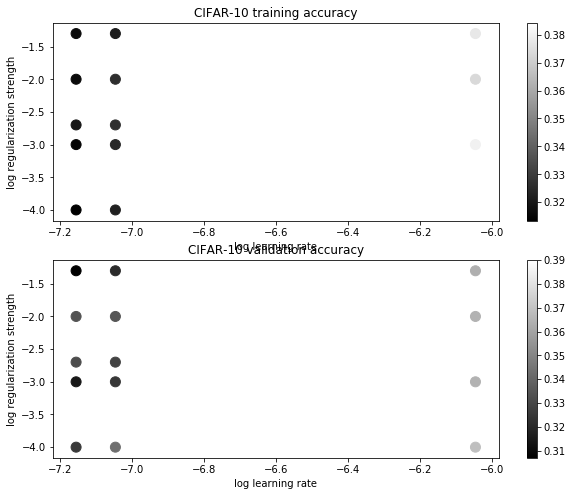

In [62]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [63]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.360000


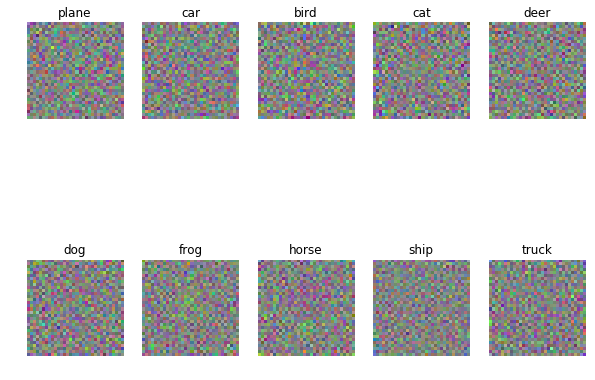

In [64]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** 
Every visualized SVM image represents average image of the class. Class deer image has a lot of green color which means that deer is in the forest background, frog image in the middle with lots of green color which represents frog's body.
